In [1]:
import os

import numpy
import pyextremes
import pandas
import scipy
import seaborn
import xarray

from knn import knn

%matplotlib inline

In [130]:
workspace_dir = '../../all_models_experiments'
# gcm_data_path = os.path.join(workspace_dir, 'intermediate', 'pr_day_CanESM5_ssp126_mean.nc')
future_gcm_data_path = os.path.join(workspace_dir, 'intermediate', 'extracted_CanESM5_ssp126.nc')
historical_gcm_data_path = os.path.join(workspace_dir, 'intermediate', 'extracted_CanESM5_historical.nc')
observed_data_path = os.path.join(workspace_dir, 'intermediate', 'extracted_mswep.nc')

In [168]:
with xarray.open_dataset(historical_gcm_data_path) as dataset:
    dataset['time'] = dataset.indexes['time'].to_datetimeindex()
    dataset = dataset.sortby('time')
    # historical_data = dataset.sel(time=slice('1985-01-01', '2014-12-31')).pr.to_series() * knn.KG_M2S_TO_MM
    # future_data = dataset.sel(time=slice('2030-01-01', '2060-01-01')).pr.to_series() * knn.KG_M2S_TO_MM
    historical_data = dataset.sel(time=slice('1985-01-01', '2014-12-31'))
    historical_data = historical_data.max(['lon', 'lat'])
    # future_data = dataset.sel(time=slice('2030-01-01', '2060-01-01'))

C:\Users\dmf\AppData\Local\Temp\ipykernel_9744\135467129.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dataset['time'] = dataset.indexes['time'].to_datetimeindex()


In [169]:
historical_series = historical_data.pr.to_series() * knn.KG_M2S_TO_MM

In [170]:
historical_series.index

DatetimeIndex(['1985-01-01 12:00:00', '1985-01-02 12:00:00',
               '1985-01-03 12:00:00', '1985-01-04 12:00:00',
               '1985-01-05 12:00:00', '1985-01-06 12:00:00',
               '1985-01-07 12:00:00', '1985-01-08 12:00:00',
               '1985-01-09 12:00:00', '1985-01-10 12:00:00',
               ...
               '2014-12-22 12:00:00', '2014-12-23 12:00:00',
               '2014-12-24 12:00:00', '2014-12-25 12:00:00',
               '2014-12-26 12:00:00', '2014-12-27 12:00:00',
               '2014-12-28 12:00:00', '2014-12-29 12:00:00',
               '2014-12-30 12:00:00', '2014-12-31 12:00:00'],
              dtype='datetime64[ns]', name='time', length=10950, freq=None)

In [171]:
with xarray.open_dataset(future_gcm_data_path) as dataset:
    dataset['time'] = dataset.indexes['time'].to_datetimeindex()
    dataset = dataset.sortby('time')
    future_data = dataset.sel(time=slice('2030-01-01', '2060-01-01'))
    future_data = future_data.max(['lon', 'lat'])

C:\Users\dmf\AppData\Local\Temp\ipykernel_9744\2799362934.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dataset['time'] = dataset.indexes['time'].to_datetimeindex()


In [180]:
future_series = future_data.pr.to_series() * knn.KG_M2S_TO_MM

In [ ]:
# pyextremes.plot_mean_residual_life(historical_data, thresholds=thresholds)

In [ ]:
# pyextremes.plot_parameter_stability(historical_data, thresholds=thresholds)

In [173]:
threshold = numpy.quantile(historical_array, q=[0.98])[0]

In [174]:
threshold

97.04793065786363

(<Figure size 768x480 with 1 Axes>, <AxesSubplot: xlabel='time', ylabel='pr'>)

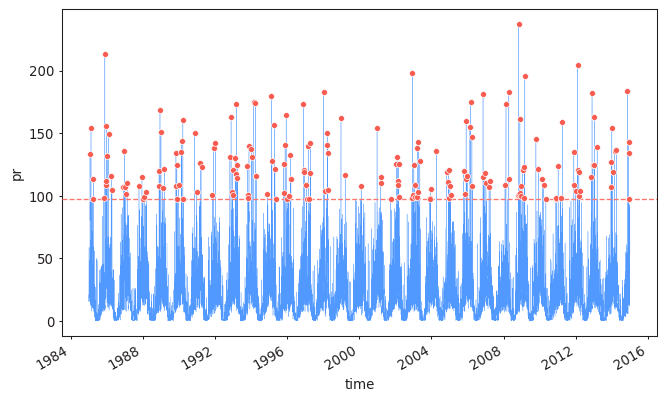

In [176]:
model = pyextremes.EVA(data=historical_series)
model.get_extremes(
    method='POT',
    extremes_type='high',
    threshold=threshold
)
model.plot_extremes()

In [177]:
model.fit_model(distribution='genpareto')
print(model)

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                            pr      Size:                              10,950
Start:                       January 1985      End:                        December 2014
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                192      Extraction method:                    POT
Type:                                high      Threshold:              97.04793065786363
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

In [178]:
c = model.distribution.mle_parameters['c']
scale = model.distribution.mle_parameters['scale']
loc = model.distribution.fixed_parameters['floc']
historical_sample = scipy.stats.genpareto.rvs(c, loc, scale, size=10000)

(<Figure size 768x480 with 1 Axes>, <AxesSubplot: xlabel='time', ylabel='pr'>)

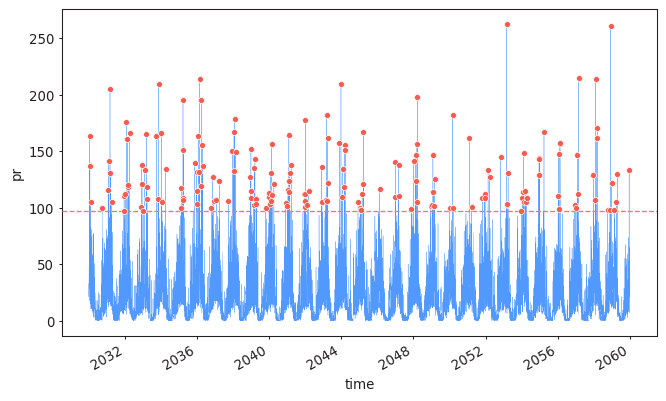

In [181]:
f_model = pyextremes.EVA(data=future_series)
f_model.get_extremes(
    method='POT',
    extremes_type='high',
    threshold=threshold
)
f_model.plot_extremes()

In [182]:
f_model.fit_model(distribution='genpareto')
print(f_model)

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                            pr      Size:                              10,951
Start:                       January 2030      End:                         January 2060
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                181      Extraction method:                    POT
Type:                                high      Threshold:              97.04793065786363
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

In [183]:
c = f_model.distribution.mle_parameters['c']
scale = f_model.distribution.mle_parameters['scale']
loc = f_model.distribution.fixed_parameters['floc']
future_sample = scipy.stats.genpareto.rvs(c, loc, scale, size=10000)

In [184]:
df = pandas.DataFrame({
    'historic_sample': numpy.sort(historical_sample),
    'future_sample': numpy.sort(future_sample),
})

<AxesSubplot: >

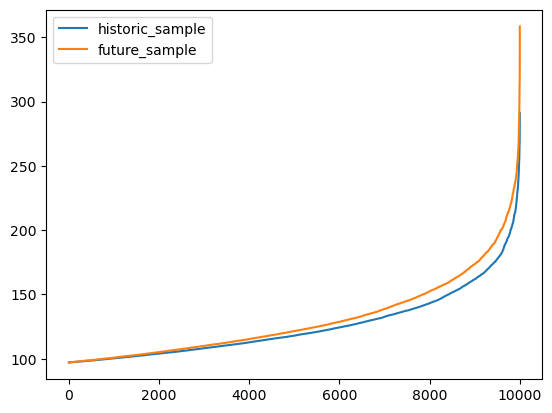

In [185]:
df.plot()

In [194]:
obs_ds = xarray.open_dataset(observed_data_path)
ds_one = obs_ds.isel(time=0)
array = ds_one.precipitation.to_numpy()

In [195]:
adjusted_values = []
for x in array.flatten():
    delta = 0
    if x >= threshold:
        idx = numpy.count_nonzero(df.historic_sample < x) - 1
        delta = df.future_sample[idx] - df.historic_sample[idx]
    adjusted_values.append(x + delta)
adjusted_array = numpy.array(adjusted_values).reshape(array.shape)

In [196]:
adj_df = pandas.DataFrame({
    'old': array.flatten(),
    'new': adjusted_array.flatten()
})

In [197]:
ds_one['new_pr'] = (('lat', 'lon'), adjusted_array)

In [198]:
ds_one['delta'] = ds_one.new_pr - ds_one.precipitation

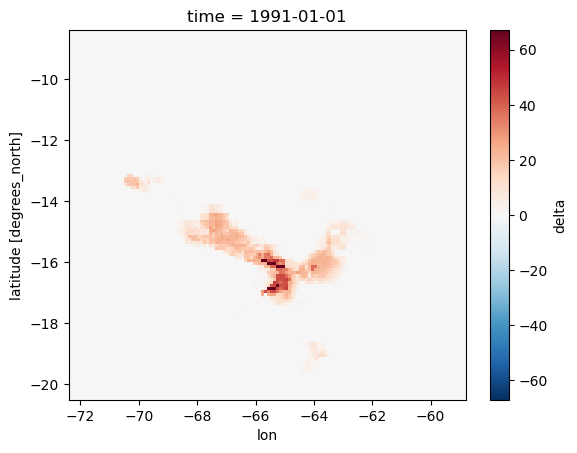

In [199]:
ds_one.delta.plot()

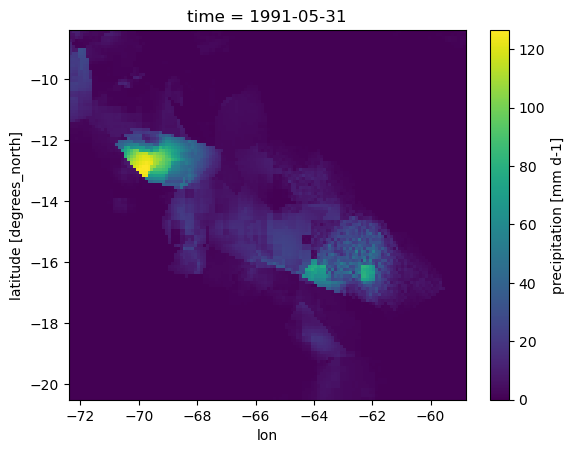

In [192]:
ds_one.precipitation.plot()

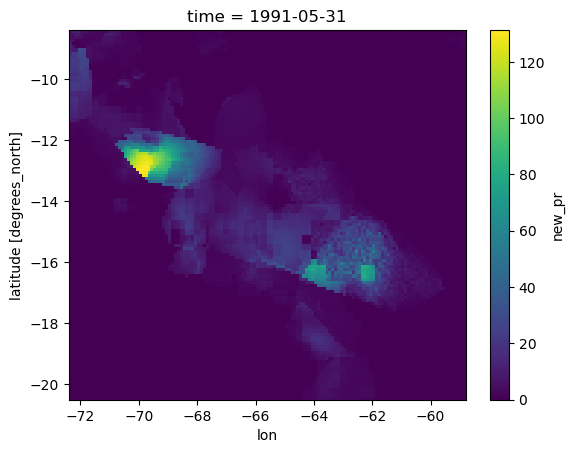

In [193]:
ds_one.new_pr.plot()